In [1]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import constants as cs

[*********************100%%**********************]  2 of 2 completed


,LONN.SW,SIKA.SW
Date,,
2023-08-08,491.200012,267.5


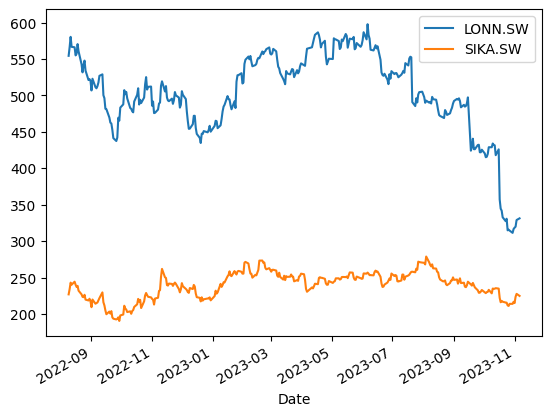

In [2]:
historical_start_date = '2022-08-09'
# Define the ticker list
tickers_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(tickers_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.plot()
display(data[data.index == pd.to_datetime('2023-08-08')])

In [ ]:
plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [ ]:
data

In [3]:
# Check all attributes of the constants module
dir(cs)


['BARRIER',
 'CONVERSION_RATIOS',
 'COUPON_PAYMENT_DATES',
 'COUPON_PAYOUT',
 'COUPON_RATE',
 'DENOMINATION',
 'EARLY_REDEMPTION_DATES',
 'EARLY_REDEMPTION_LEVEL',
 'EARLY_REDEMPTION_LEVELS',
 'EARLY_REDEMPTION_OBSERVATION_DATES',
 'EARLY_REDEMPTION_OBSERVATION_FREQUENCY',
 'FINAL_FIXING_DATE',
 'FIRST_PRODUCT_PRICE_EST_DATE',
 'HISTORICAL_START_DATE',
 'INITIAL_FIXING_DATE',
 'ISSUE_PRICE_PERCENTAGE',
 'PAYMENT_DATE',
 'REDEMPTION_DATE',
 'SIX_HOLIDAY_DATES',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'pd']

In [4]:
print(cs.SIX_HOLIDAY_DATES)

[Timestamp('2023-01-02 00:00:00'), Timestamp('2023-04-07 00:00:00'), Timestamp('2023-04-10 00:00:00'), Timestamp('2023-05-01 00:00:00'), Timestamp('2023-05-18 00:00:00'), Timestamp('2023-05-29 00:00:00'), Timestamp('2023-08-01 00:00:00'), Timestamp('2023-12-25 00:00:00'), Timestamp('2023-12-26 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2024-01-02 00:00:00'), Timestamp('2024-03-29 00:00:00'), Timestamp('2024-04-01 00:00:00'), Timestamp('2024-05-01 00:00:00'), Timestamp('2024-05-09 00:00:00'), Timestamp('2024-05-20 00:00:00'), Timestamp('2024-08-01 00:00:00'), Timestamp('2024-12-24 00:00:00'), Timestamp('2024-12-25 00:00:00'), Timestamp('2024-12-26 00:00:00'), Timestamp('2024-12-31 00:00:00')]


In [ ]:

# Ensure that the dates you are trying to drop exist in the index
dates_to_drop = [date for date in cs.SIX_HOLIDAY_DATES if date in data.index]
print(dates_to_drop)
# Drop the dates
data2 = data.drop(dates_to_drop)
display(data2)


In [ ]:
input_date = cs.FIRST_PRODUCT_PRICE_EST_DATE
sim_start_date = input_date + pd.Timedelta(days = 1)
last_avai_price_date = sim_start_date - pd.Timedelta(days = 1)

S_t = [data.loc[last_avai_price_date, ticker] for ticker in tickers_list] # Stock price of the 0th day of simulation
time_steps_per_year = 252
dt = 1/time_steps_per_year
r = 1.750/100 
# TODO: from the simulation date to the final fixing date is roughly 8 months, so I choose a 6-month bond yield that is closest to the time horizon (8 months)
# And then find the closest date to the simulation date (around August 10)
T = 63 # Number of simulation days (#TODO: To be changed later)
num_ticker = len(tickers_list) # Number of stocks

# TODO: Ask if can use historical?
# Use historical data to estimate covariance matrix. (up to last_avai_price date?)

# TODO: Save into a df with dates if needed

hist_data = data[data.index < sim_start_date].tail(time_steps_per_year)
display(hist_data)

log_returns_list = []
for ticker in tickers_list:
    # display(data[ticker], data[ticker].shift(1))
    log_returns = np.log(hist_data[ticker] / hist_data[ticker].shift(1)) # np.log is natural log, (P_i/P_i-1)
    log_returns.dropna(inplace = True) # A series
    log_returns_list.append(log_returns)
    # print(type(log_returns))

# print(log_returns_list)
# print(np.shape(log_returns_list))


# print(f"np.array {np.array(log_returns_list)}")
cov_matrix = np.cov(np.array(log_returns_list))
print(f"Covariance matrix is:\n {cov_matrix}\n")
print(f"The shape is {np.shape(cov_matrix)}\n")

print(f"Correlation between the two var is {cov_matrix[0][1] / (cov_matrix[0][0] * cov_matrix[1][1]) ** 0.5}") # Correct

L = np.linalg.cholesky(cov_matrix)
print(f"The matrix after Cholesky decomposition is:\n {L}\n")

print(f"The multiplication of L and L transpose is:\n {np.dot(L, L.T)}\n") 

sim_data = pd.DataFrame(np.zeros((T, num_ticker)), columns = [tickers_list])

# display(sim_data)
# TODO: N number of simulations
 
# print(sim_data.loc[0, "LONN.SW"])
for t in range(T): # TODO: change to num of days to sim (date range or sth)
    Z = np.random.normal(0, 1, num_ticker) # returns a scalar if size is not specified
    for i in range(num_ticker): # day need to go first, 
        if t == 0: prev_price = S_t[i]
        else: prev_price = sim_data.loc[t - 1, tickers_list[i]].item()
        LZ = np.dot(L, Z)

        print(type(prev_price), type(cov_matrix[i][i]), type(LZ[i]))
        print(r, cov_matrix[i][i], LZ[i])
        sim_data.loc[t, tickers_list[i]] = prev_price * np.exp(r * dt - 0.5 * cov_matrix[i][i] * dt + LZ[i]) # The cov matrix and L need to be computed on the fly

display(sim_data)

sim_data.columns = ["simulated_" + ticker for ticker in tickers_list]

# A dataframe with both validation data and simulated data

val_df = data[data.index >= sim_start_date]
print(len(val_df), len(sim_data))
# Ensure sim_data has the same index as val_df
sim_data.index = val_df.index

# Concatenate val_df and sim_data along columns
val_df_with_sim = pd.concat([val_df, sim_data], axis=1)
display(val_df_with_sim)

# for t in time step from simulation start until end date
# TODO: get market calendar date times: minus weekdays, holidays

val_df_with_sim.plot()
